In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("lending_club.csv", low_memory=False)

In [9]:

# Target encoding
default_status = ["Charged Off", "Default", "Does not meet the credit policy. Charged Off", "Late (31-120 days)"]
df['target'] = df['loan_status'].apply(lambda x: 1 if x in default_status else 0)

# Drop identifiers / leaks
drop_cols = ['id', 'member_id', 'url', 'desc', 'title', 'loan_status']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

/tmp/ipykernel_69375/2535346811.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = df['loan_status'].apply(lambda x: 1 if x in default_status else 0)


In [3]:

num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# Fill missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = LabelEncoder().fit_transform(df[col])


In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['target'])
y = df['target']

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)



In [ ]:
top_features = importances.sort_values(ascending=False).head(17)

/tmp/ipykernel_41931/2811776067.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


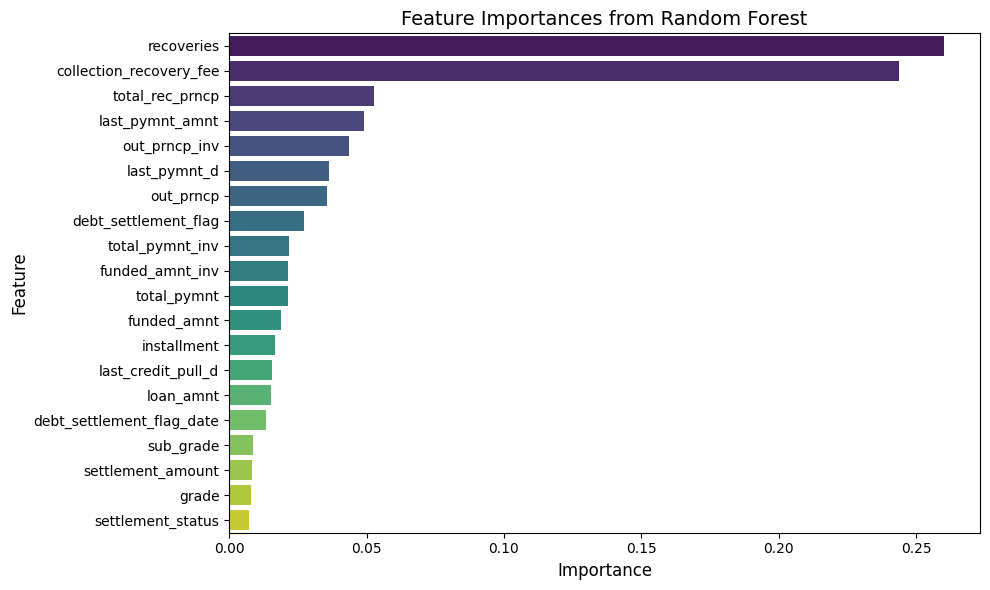

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort values
importances_sorted = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_sorted.values,
    y=importances_sorted.index,
    palette="viridis"
)
plt.title("Feature Importances from Random Forest", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
top_features

recoveries                   0.267378
collection_recovery_fee      0.204989
total_rec_prncp              0.065472
last_pymnt_amnt              0.053814
out_prncp                    0.042868
last_pymnt_d                 0.040179
out_prncp_inv                0.036188
debt_settlement_flag         0.024670
total_pymnt                  0.021496
total_pymnt_inv              0.019819
funded_amnt                  0.019620
last_credit_pull_d           0.019222
loan_amnt                    0.018078
funded_amnt_inv              0.017870
debt_settlement_flag_date    0.013326
installment                  0.013063
grade                        0.010341
dtype: float64

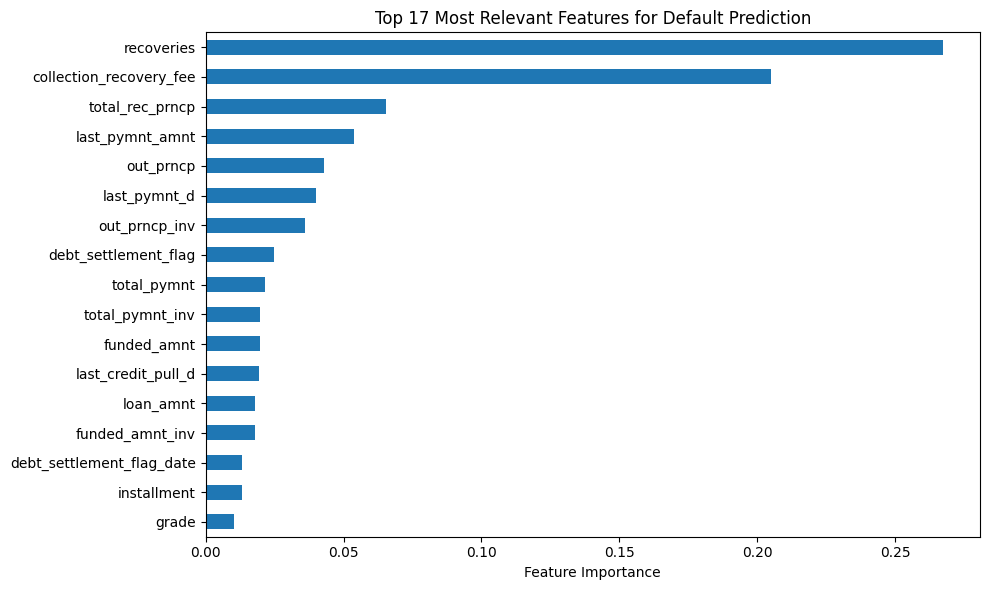

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_features[::-1].plot(kind='barh')
plt.title('Top 17 Most Relevant Features for Default Prediction')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [6]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

In [22]:
selected_features = [
    'emp_title',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'loan_amnt',
    'term',
    'purpose',
    'application_type',
    'disbursement_method'
]

df = df[selected_features + ['target']]

In [23]:
# Fill missing numeric values with median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical/date columns with mode
cat_cols = df.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [24]:
# Customer-input categorical columns
cat_cols = [
    'emp_title',
    'home_ownership',
    'term',
    'purpose',
    'application_type',
    'disbursement_method'
]

# Encode each categorical column
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# Quick check
print(df[cat_cols].head())

   emp_title  home_ownership  term  purpose  application_type  \
0     424092               5     0       10                 0   
1     134864               1     1       10                 0   
2     464206               1     0       10                 0   
3       6564               1     0       10                 0   
4      73045               1     1       10                 0   

   disbursement_method  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  


In [25]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=['target'])
y = df['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape for Conv1D: (samples, timesteps=n_features, channels=1)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


print(X_train.shape, X_test.shape)


(1808534, 9, 1) (452134, 9, 1)


In [14]:
len(X_test)

452134

In [15]:
len(y_test)

452134

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Conv1D, BatchNormalization, MaxPooling1D,
    GlobalMaxPooling1D, Dense, Dropout
)

def build_cnn_1d(input_shape, drop_rate=0.3):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

n_features = X_train.shape[1]
model = build_cnn_1d((n_features, 1))
model.summary()


/home/stonie/miniconda3/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 9, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,049 (133.00 KB)

 Trainable params: 33,665 (131.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [28]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=256,
    verbose=1
)


Epoch 1/5
7065/7065 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9998 - auc: 0.0000e+00 - loss: 4.3640e-04 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.5862e-10
Epoch 2/5
7065/7065 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 5.3760e-08 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 4.5063e-14
Epoch 3/5
7065/7065 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 2.8186e-09 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.5117e-15
Epoch 4/5
7065/7065 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 1.3584e-10 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 7.7341e-17
Epoch 5/5
7065/7065 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 3.0888e-11 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 4.2637e-18


2025-11-24 23:34:05.803808: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-24 23:34:06.898678: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_127', 24 bytes spill stores, 24 bytes spill loads



Test Accuracy: 1.0000
Test AUC: 0.0000
14130/14130 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step


/home/stonie/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/stonie/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/stonie/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/stonie/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y

Precision: 0.0000
Recall: 0.0000
AUC: nan


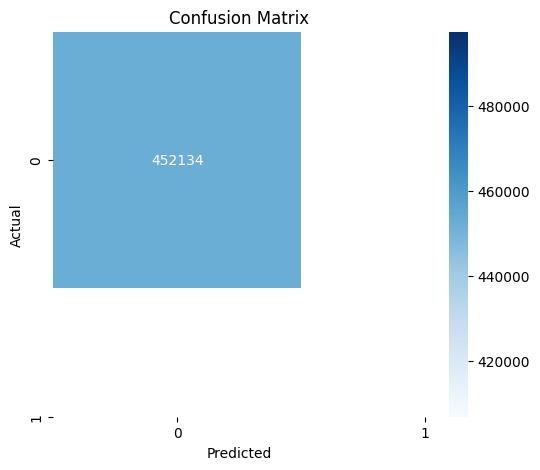

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Evaluate model for loss, accuracy, AUC (if compiled with metrics=['accuracy', 'AUC'])
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC: {auc:.4f}")

# 2. Predict classes for X_test
y_pred_prob = model.predict(X_test)  # predicted probabilities
y_pred = np.round(y_pred_prob).astype(int)  # convert probabilities to 0 or 1

# 3. Compute Precision, Recall, AUC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {roc_auc:.4f}")

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

14130/14130 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


/home/stonie/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


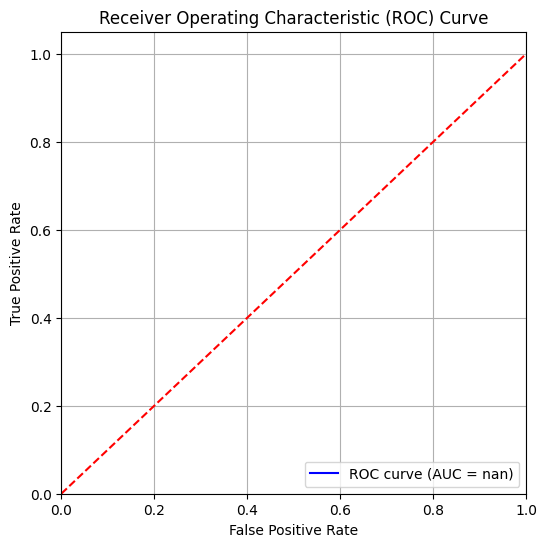

In [19]:
# Predict probabilities for positive class
from sklearn.metrics import roc_curve, auc


y_pred_prob = model.predict(X_test)

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

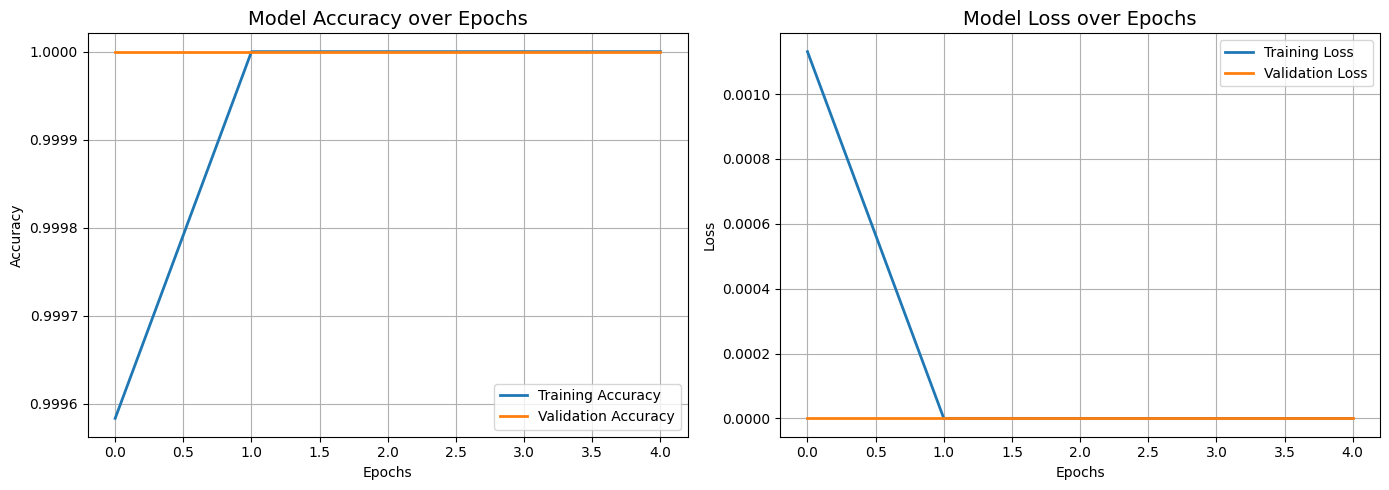

In [20]:
import matplotlib.pyplot as plt

# Assuming `history` is your model.fit() output
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
X_test.shape

(452134, 17, 1)

In [ ]:
predictions = model.predict(X_test)

14130/14130 ━━━━━━━━━━━━━━━━━━━━ 10s 674us/step


In [ ]:
type(predictions)

numpy.ndarray

In [ ]:
len(predictions)

452134

In [ ]:
default_indices = y_test[y_test == 1].index
print(default_indices)

Index([1570054,  722279,  731326, 1942000,  625423,  625863, 1486213, 1629331,
        826396,  669280,
       ...
       1254977,  777978,  292344, 1928252,  645692,  859362, 1145278,  803520,
       2029667, 1491888],
      dtype='int64', length=56717)


In [ ]:
default_indices_list = list(default_indices)
print(default_indices_list)


[1570054, 722279, 731326, 1942000, 625423, 625863, 1486213, 1629331, 826396, 669280, 995663, 914475, 1957224, 1613550, 1840375, 1154722, 636814, 952892, 1086690, 957040, 948893, 1015422, 1933865, 1337696, 1041413, 635844, 1110200, 1179103, 1931888, 2132961, 2191783, 1453784, 326398, 2148533, 1409812, 495460, 579488, 1906935, 2073854, 1285090, 971238, 804096, 854046, 1747570, 1702423, 650957, 1248901, 1934847, 2182303, 1665935, 322895, 1843827, 1168435, 1321042, 865565, 1123100, 1009476, 675061, 887650, 464612, 705654, 811491, 1333545, 1537191, 918703, 940750, 1914570, 374281, 1085968, 2010191, 1719589, 2125536, 531124, 1675865, 1244763, 753081, 2033056, 518146, 748777, 1499772, 563313, 1408646, 880142, 697916, 1942997, 1660239, 972549, 2016133, 1821148, 1902139, 1521140, 1424414, 565024, 1590669, 477329, 604706, 1881508, 1941333, 489172, 1174432, 473399, 1053790, 498045, 1140255, 689811, 1157537, 990458, 958937, 1002201, 2124135, 1167837, 410759, 2180530, 1720326, 1461434, 2042353, 883

In [21]:
sample_index = 1570054  # pick any test sample
X_sample = X_test[sample_index].reshape(1, n_features, 1)  # correct reshape
y_true = y_test.iloc[sample_index]

prob_default = float(model.predict(X_sample)[0][0])
pred_class = 1 if prob_default >= 0.5 else 0
print(f"Predicted Probability of Default: {prob_default:.4f}")
print(f"Predicted Class: {'Default' if pred_class==1 else 'Fully Paid'}")
print(f"True Label: {'Default' if y_true==1 else 'Fully Paid'}")

IndexError: index 1570054 is out of bounds for axis 0 with size 452134

In [ ]:
default_positions = np.where(y_test.values == 1)[0]
default_positions

array([    15,     18,     34, ..., 452102, 452111, 452126],
      shape=(56717,))

In [20]:
# 1. Get the original indices from y_test
test_indices = y_test.index if hasattr(y_test, "index") else np.arange(len(y_test))

# 2. Reshape for CNN input
X_all = X_test.reshape(len(X_test), X_test.shape[1], 1)

# 3. Convert y_test to NumPy array
y_true = np.array(y_test)

# 4. Predict probabilities
y_pred_probs = model.predict(X_all, verbose=0)

# 5. Convert probabilities to binary classes
y_pred_class = (y_pred_probs >= 0.5).astype(int)

# 6. Combine results with their original indices
results_df = pd.DataFrame({
    'Index': test_indices,
    'Pred_Prob': y_pred_probs.flatten(),
    'Pred_Class': np.where(y_pred_class.flatten() == 1, 'Default', 'Fully Paid'),
    'True_Label': np.where(y_true == 1, 'Default', 'Fully Paid')
})

# 7. Show first 10 predictions
print("First 10 predictions:")
print(results_df.head(10))

# 8. (Optional) Filter by probability threshold
threshold = 0.5
filtered_results = results_df[results_df['Pred_Prob'] > threshold]

print(f"\nFiltered (Pred_Prob > {threshold}):")
print(filtered_results.head(10))

First 10 predictions:
     Index  Pred_Prob  Pred_Class  True_Label
0  1688918   0.000010  Fully Paid  Fully Paid
1   296880   0.000691  Fully Paid  Fully Paid
2   698787   0.000047  Fully Paid  Fully Paid
3  1827063   0.000696  Fully Paid  Fully Paid
4   305380   0.000754  Fully Paid  Fully Paid
5  1370532   0.000720  Fully Paid  Fully Paid
6  1044740   0.001033  Fully Paid  Fully Paid
7   721301   0.000035  Fully Paid  Fully Paid
8   971882   0.000070  Fully Paid  Fully Paid
9  1980270   0.000059  Fully Paid  Fully Paid

Filtered (Pred_Prob > 0.5):
      Index  Pred_Prob Pred_Class True_Label
15  1570054   0.999978    Default    Default
18   722279   0.996746    Default    Default
34   731326   1.000000    Default    Default
48  1942000   1.000000    Default    Default
56   625423   1.000000    Default    Default
59   625863   1.000000    Default    Default
62  1486213   1.000000    Default    Default
63  1629331   1.000000    Default    Default
69   826396   1.000000    Default    D

In [34]:
# Assuming you kept selected_features when building X
feature_names = selected_features  # list of 17 feature names you used
sample_idx = 296880
X_sample = X_test[sample_idx]  # shape: (n_features,)

sample_df = pd.DataFrame(X_sample.reshape(1, -1), columns=feature_names)
print(sample_df.T)  # transpose to show features as rows

                                  0
recoveries                 0.000000
collection_recovery_fee    0.000000
total_rec_prncp            0.420000
last_pymnt_amnt            0.013159
out_prncp                  0.000000
last_pymnt_d               0.000000
out_prncp_inv              0.000000
debt_settlement_flag       0.000000
total_pymnt                0.315858
total_pymnt_inv            0.315858
funded_amnt                0.412658
last_credit_pull_d         0.000000
loan_amnt                  0.412658
funded_amnt_inv            0.420000
debt_settlement_flag_date  0.000000
installment                0.320969
grade                      0.166667


In [29]:
def simulate_api_prediction(raw_input_dict, scaler, model, feature_names):
    """
    Simulate an API call for a 1D CNN credit default prediction.
    
    Args:
        raw_input_dict (dict): raw feature values keyed by feature name.
        scaler (sklearn MinMaxScaler): fitted scaler from training.
        model (tf.keras.Model): trained 1D CNN model.
        feature_names (list): ordered list of features used in training.
        
    Returns:
        dict: contains original input, scaled input, predicted probability, predicted class.
    """
    # 1. Convert raw input dict to DataFrame in correct order
    X_raw_df = pd.DataFrame([raw_input_dict], columns=feature_names)
    
    # 2. Scale input using the same scaler
    X_scaled = scaler.transform(X_raw_df.values)
    
    # 3. Reshape for 1D CNN
    X_scaled_reshaped = X_scaled.reshape(1, X_scaled.shape[1], 1)
    
    # 4. Make prediction
    prob_default = float(model.predict(X_scaled_reshaped, verbose=0)[0][0])
    pred_class = 1 if prob_default >= 0.5 else 0
    
    # 5. Return results
    result = {
        "Original_Input": raw_input_dict,
        "Scaled_Input": X_scaled.flatten().tolist(),
        "Pred_Prob": prob_default,
        "Pred_Class": "Default" if pred_class==1 else "Fully Paid"
    }
    
    return result

# --- Example usage ---

# Raw features from row 220982
api_input = {
    'recoveries': 0.00,
    'collection_recovery_fee': 0.00,
    'total_rec_prncp': 0.00,
    'last_pymnt_amnt': 0.00,
    'out_prncp': 9500.00,
    'last_pymnt_d': 737091.00,
    'out_prncp_inv': 9500.00,
    'debt_settlement_flag': 0.00,
    'total_pymnt': 0.00,
    'total_pymnt_inv': 0.00,
    'funded_amnt': 9500.00,
    'last_credit_pull_d': 737091.00,
    'loan_amnt': 9500.00,
    'funded_amnt_inv': 9500.00,
    'debt_settlement_flag_date': 737091.00,
    'installment': 384.34,
    'grade': 4.00,
    'target': 1.00
}

# Simulate prediction
result = simulate_api_prediction(api_input, scaler, model, selected_features)

# Create a readable DataFrame
results_df = pd.DataFrame({
    'Pred_Prob': [result['Pred_Prob']],
    'Pred_Class': [result['Pred_Class']],
    'Original_Input': [result['Original_Input']],
    'Scaled_Input': [result['Scaled_Input']]
})

# Transpose for easier reading
print(results_df.T)


                                                                0
Pred_Prob                                                0.991521
Pred_Class                                                Default
Original_Input  {'recoveries': 0.0, 'collection_recovery_fee':...
Scaled_Input    [0.0, 0.0, 0.0, 0.0, 0.23750000000000002, 1.0,...


/home/stonie/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [27]:
new_selected_features = [
    'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'last_pymnt_amnt',
    'out_prncp', 'last_pymnt_d', 'out_prncp_inv', 'debt_settlement_flag',
    'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'last_credit_pull_d',
    'loan_amnt', 'funded_amnt_inv', 'debt_settlement_flag_date', 'installment',
    'grade','target'
]

In [24]:
default_indices = df[df['target'] == 1].index
print(f"Number of defaulted loans: {len(default_indices)}")

Number of defaulted loans: 283583


In [25]:
default_indices[8]

np.int64(7783)

In [28]:
row_idx = 7783

sample_row = df.loc[row_idx, new_selected_features]  # only the features used in training
print(sample_row)

recoveries                        0.00
collection_recovery_fee           0.00
total_rec_prncp                   0.00
last_pymnt_amnt                   0.00
out_prncp                      9500.00
last_pymnt_d                 737091.00
out_prncp_inv                  9500.00
debt_settlement_flag              0.00
total_pymnt                       0.00
total_pymnt_inv                   0.00
funded_amnt                    9500.00
last_credit_pull_d           737091.00
loan_amnt                      9500.00
funded_amnt_inv                9500.00
debt_settlement_flag_date    737091.00
installment                     384.34
grade                             4.00
target                            1.00
Name: 7783, dtype: float64


In [11]:
import joblib
joblib.dump(scaler, "credit_default_scaler.save")
model.save("credit_default_cnn_model.keras")

